In [1]:
datasetName = 'brain_PFC_Zhong2018'
#datasetName value: organ_tissue_authorYear without space
dataFormat = 'tsv'
#dataFormat value: tsv (tab separated), 10X (sparse)
setwd("/stor/public/hcad/brain_PFC_Zhong2018/")

In [2]:
library(Seurat)
library(data.table)
library(ggplot2)
# Load the organized dataset
if(dataFormat == 'tsv'){
    data.matrix <- data.table::fread(paste0(datasetName,"_expression.tsv.gz"), h = T, data.table = F)
} else{
   # system(paste0("tar -zxvf ", datasetName, "_expression.tar.gz")) #Invoke the unix command
   data.matrix <- Read10X(data.dir = paste0(datasetName,"_expression"))
   # data.dir: Directory containing the matrix.mtx, genes.tsv (or features.tsv), and barcodes.tsv files provided by 10X.
}
# Load the metadata and annotation
data.metadata <- read.table(file = paste0(datasetName,"_metadata.tsv"), h = T, sep = "\t", row.names = 5)
data.annotation <- read.table(file = paste0(datasetName,"_annotation.tsv"), h = T, sep = "\t", row.names = 1)


In [3]:
dim(data.matrix)

[1] 24153  2395

In [4]:
row.names(data.matrix) <- data.matrix[, 1]
data.matrix <- data.matrix[, -1]
data.matrix[1:5, 1:5]
data.metadata[1:5, ]
data.annotation[1:5,]

,GW08_PFC1_sc1,GW08_PFC1_sc2,GW08_PFC1_sc3,GW08_PFC1_sc4,GW08_PFC1_sc5
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
A1BG,4.54,0,0.00,0,0.00
A1BG-AS1,0.00,0,0.00,0,0.00
A1CF,0.00,0,0.00,0,0.00
A2M,4.54,0,8.87,0,872.68
A2M-AS1,0.00,0,0.00,0,2.19


,organ,region,subregion,sample_status,donor_ID,donor_gender,donor_age
,<fct>,<fct>,<lgl>,<fct>,<lgl>,<lgl>,<fct>
GW08_PFC1_sc1,Brain,PFC,NA,normal,NA,NA,GW08
GW08_PFC1_sc2,Brain,PFC,NA,normal,NA,NA,GW08
GW08_PFC1_sc3,Brain,PFC,NA,normal,NA,NA,GW08
GW08_PFC1_sc4,Brain,PFC,NA,normal,NA,NA,GW08
GW08_PFC1_sc5,Brain,PFC,NA,normal,NA,NA,GW08


[1] NA NA NA NA NA

In [6]:
# Pre-processing
min.cells = 3
min.features = 1000
# nFeature_RNA_range = c(min.features, 7000)
# percent.mt.thre = 15
# Modify the default value of these parameters according to original paper
dataobj <- CreateSeuratObject(counts = data.matrix, project = datasetName, min.cells = min.cells, min.features = min.features, meta.data = data.metadata)
# dataobj <- AddMetaData(dataobj, metadata = data.annotation)
# QC
dataobj[["percent.mt"]] <- PercentageFeatureSet(dataobj, pattern = "^[Mm][Tt]")
dataobj <- subset(dataobj, subset = nFeature_RNA > min.features)
dataobj@assays

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”


$RNA
Assay data with 20262 features for 2344 cells
First 10 features:
 A1BG, A1BG-AS1, A1CF, A2M, A2M-AS1, A2ML1, A2MP1, A3GALT2, A4GALT,
A4GNT 


In [7]:
# Normalization
# Two approaches
# 1. run standard log normalization 
dataobj <- NormalizeData(dataobj, normalization.method = "LogNormalize", scale.factor = 10000)
dataobj <- FindVariableFeatures(dataobj) # default feature number, nfeatures = 2000
dataobj <- ScaleData(dataobj, features = VariableFeatures(dataobj))
# 2. run sctransform 
# dataobj <- SCTransform(dataobj, vars.to.regress = "percent.mt", do.correct.umi = TRUE, do.scale = TRUE, do.center = TRUE)

Centering and scaling data matrix



In [8]:
length(VariableFeatures(dataobj))

[1] 2000

In [9]:
# Dimensional Reduction
dataobj <- RunPCA(dataobj, features = VariableFeatures(object = dataobj))
# Determine the ‘dimensionality’ of the dataset according to elbow plot

PC_ 1 
Positive:  SOX4, BCL11A, C1orf61, IGFBPL1, NEUROD6, LINC01158, CSRP2, HIST1H4C, RBP1, FABP5 
	   H2AFZ, MDK, ZBTB20, EIF1B, FABP7, VCAN, NRXN1, PPP1R17, PTPRZ1, ARL4D 
	   C4orf48, DLL3, ASCL1, PALMD, SLA, GPM6B, EOMES, CNR1, PLS3, SMIM18 
Negative:  C1QC, P2RY12, LAPTM5, C3, AIF1, CSF1R, CX3CR1, C1QB, C1QA, CD53 
	   VSIG4, FOLR2, TREM2, TYROBP, FCGR1A, C10orf54, FPR1, FCGR3A, PLD4, RGS1 
	   FCER1G, P2RY13, OLFML3, SLCO2B1, FCGRT, ITGB2, CYBB, CD68, ALOX5AP, SPP1 
PC_ 2 
Positive:  PTN, PON2, PPAP2B, TTYH1, BCAN, SLC1A3, CLU, CD9, HOPX, VIM 
	   DBI, HSPB1, MT2A, HES1, ATP1A2, NKAIN4, TNC, EDNRB, SCRG1, RAMP1 
	   S100A16, NUSAP1, FAM107A, CDK1, SPARC, HMGB2, MT3, PTPRZ1, RAB31, PTTG1 
Negative:  SOX4, FTL, BCL11A, SLA, DLX2, DLX5, DLX1, PLS3, ERBB4, NEUROD6 
	   MAF, GAD2, DLX6-AS1, PDE4DIP, LHX6, PALMD, CSRP2, GAD1, PDZRN3, PDZRN4 
	   MALAT1, MEG3, EIF1B, MEF2C, SCGN, PTPRR, ARL4D, CXCR4, SCG2, NOL4 
PC_ 3 
Positive:  MEF2C, MEG3, CAMK2B, CHD5, ARPP21, NRXN2, KCNQ1OT1, LPL,

Warning message in ElbowPlot(dataobj, ndims = 100):
“The object only has information for 50 reductions”


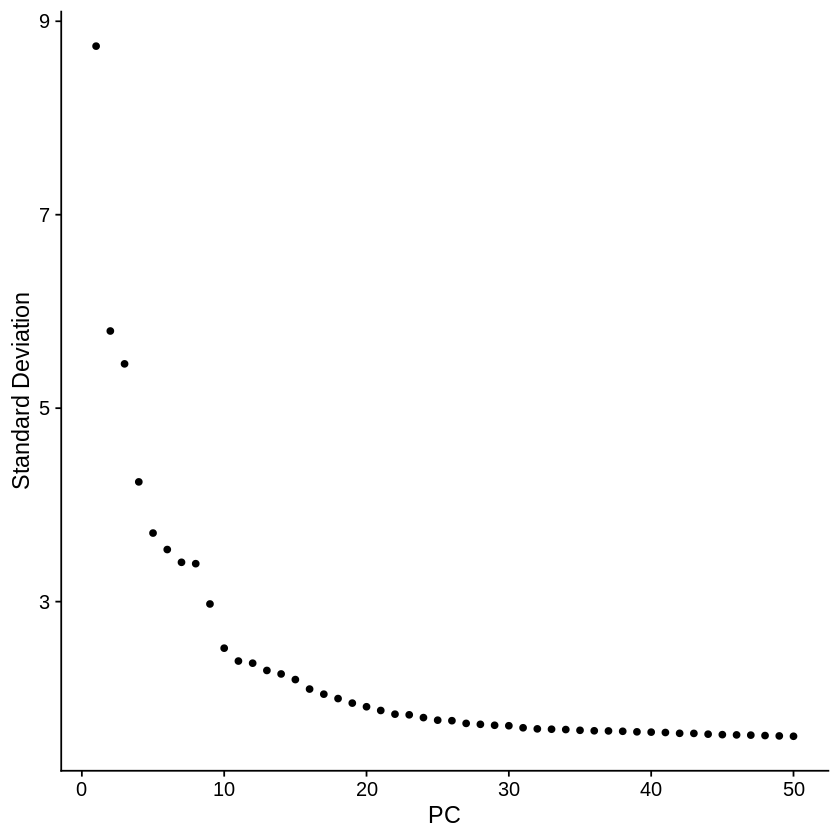

In [10]:
# dataobj <- JackStraw(dataobj, num.replicate = 100)
# dataobj <- ScoreJackStraw(dataobj, dims = 1:20)
# JackStrawPlot(dataobj, dims = 1:15)
ElbowPlot(dataobj, ndims = 100) 

In [13]:
# Cluster the cells
pcDim = 20
dataobj <- FindNeighbors(dataobj, reduction = "pca", dims = 1:pcDim, nn.eps = 0.5)
dataobj <- FindClusters(dataobj, resolution = 0.6, n.start = 10)
# umap
dataobj <- RunUMAP(dataobj, dims = 1:pcDim)

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 2344
Number of edges: 84500

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8631
Number of communities: 12
Elapsed time: 0 seconds


04:22:12 UMAP embedding parameters a = 0.9922 b = 1.112

04:22:12 Read 2344 rows and found 20 numeric columns

04:22:12 Using Annoy for neighbor search, n_neighbors = 30

04:22:12 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*

|

04:22:12 Writing NN index file to temp file /tmp/Rtmpc2TQVc/file16f635bf38bf

04:22:12 Searching Annoy index using 1 thread, search_k = 3000

04:22:13 Annoy recall = 100%

04:22:13 Commencing smooth kNN distance calibration using 1 thread

04:22:14 Initializing from normalized Laplacian + noise

04:22:14 Commencing optimization for 500 epochs, with 96418 positive edges

04:22:19 Optimization finished



Warning message:
“Using `as.character()` on a quosure is deprecated as of rlang 0.3.0.
Please use `as_label()` or `as_name()` instead.
This warning is displayed once per session.”


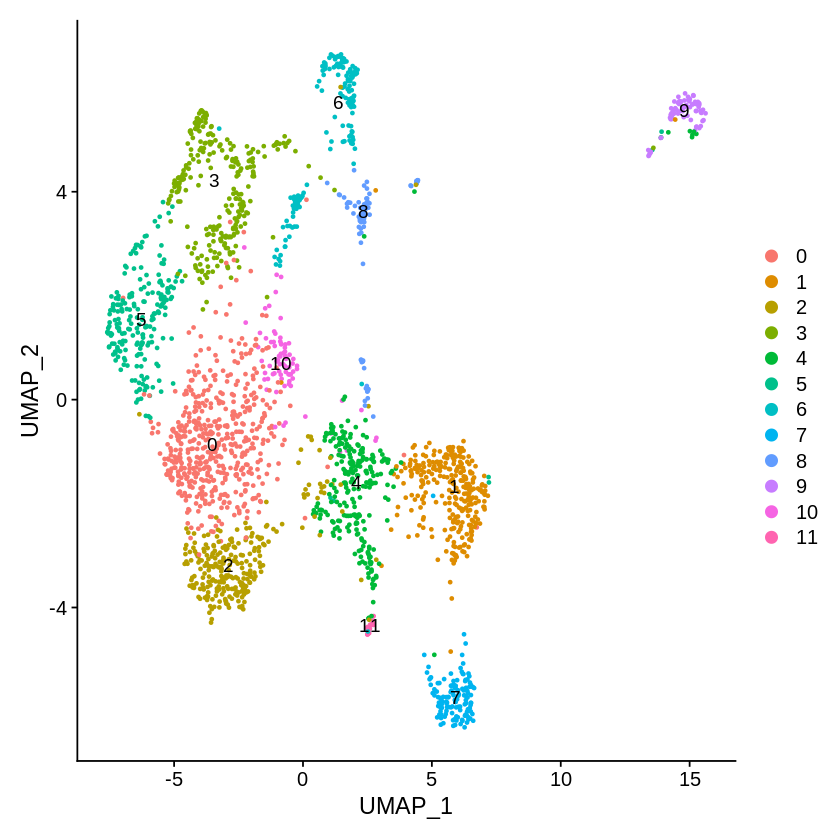

In [14]:
p_umap <- DimPlot(dataobj, reduction = "umap", label = TRUE)
p_umap

In [17]:
ggsave(paste0(datasetName,".seurat.umap.tiff"), plot = p_umap, width = 8, height = 5)

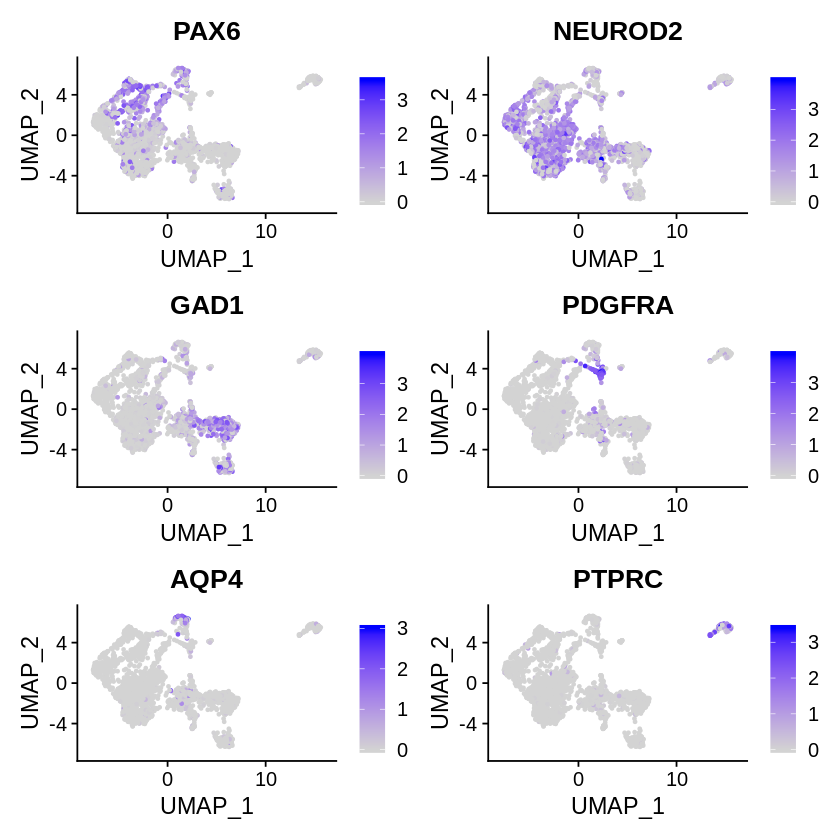

In [15]:
# PAX6, NEUROD2, GAD1, PDGFRA, AQP4 and PTPRC were used as markers to identify the major cell types in the brain: 
# neural progenitor cells (NPCs), excitatory neurons, interneurons, oligodendrocyte progenitor cells (OPCs), astrocytes and microglia
p <- FeaturePlot(dataobj, features = c("PAX6", "NEUROD2", "GAD1", "PDGFRA", "AQP4", "PTPRC"))
p

In [18]:
ggsave(paste0(datasetName,".featuremap.tiff"), plot = p, width = 10, height = 10)

In [20]:
# Finding cluster markers 
dataobj.markers <- FindAllMarkers(dataobj, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25)
write.table(dataobj.markers, file = paste0(datasetName,".seurat.markers.txt"), sep = "\t", quote = F, row.names = F, col.names = T)

Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6

Calculating cluster 7

Calculating cluster 8

Calculating cluster 9

Calculating cluster 10

Calculating cluster 11



In [16]:
new.cluster.ids <- c('Brain-Nerve tissue-Excitatory neuron-NEUROD2', 'Brain-Nerve tissue-Inhibitory neuron-GAD1', 'Brain-Nerve tissue-Excitatory neuron-NEUROD2',
                    'Brain-Nerve tissue-Neural progenitor cell-PAX6', 'Brain-Nerve tissue-Excitatory neuron-NEUROD6', 'Brain-Nerve tissue-Excitatory neuron-CSPR2',
                    'Brain-Nerve tissue-Astrocyte-AQP4', 'Brain-Nerve tissue-Inhibitory neuron-GAD1', 'Brain-Nerve tissue-Oligodendrocyte progenitor cell-PDGFRA',
                    'Brain-Nerve tissue-Microglia-PTPRC', 'Brain-Nerve tissue-Excitatory neuron-NEUROD2', 'Unknown')
names(new.cluster.ids) <- levels(dataobj)
dataobj <- RenameIdents(dataobj, new.cluster.ids)

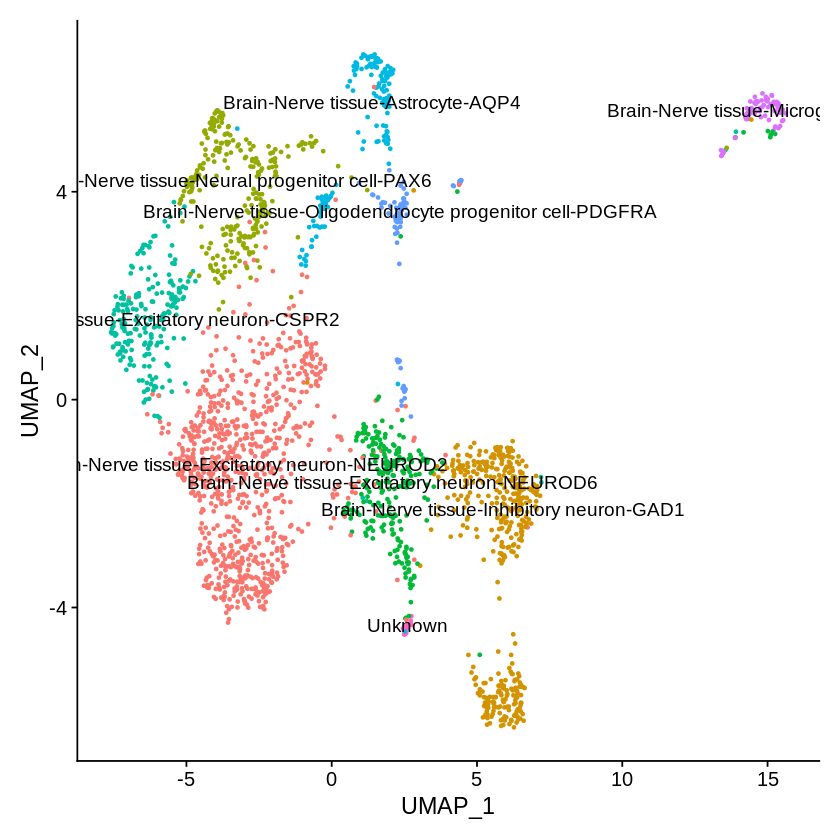

In [17]:
p_umap2 <- DimPlot(dataobj, reduction = "umap", label = TRUE) + NoLegend()
p_umap2

In [18]:
ggsave(paste0(datasetName,".seurat.umap_hcad.tiff"), plot = p_umap2, width = 8, height = 5)

In [19]:
saveRDS(dataobj, file = paste0(datasetName,".seuratobj.rds"))